# lib

In [96]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from collections import deque
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate, Bidirectional
from tensorflow.keras.layers import LSTM , BatchNormalization, AveragePooling1D, Flatten, GRU, SimpleRNN
from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas_ta as ta
plt.style.use('seaborn-darkgrid')

# preprocessing data

In [97]:
path_to_file = "btc.csv"

In [98]:
btc = pd.read_csv(path_to_file, skiprows=1)
btc = btc[::-1]
# btc = btc[2100:]
btc = btc.astype({'date': 'datetime64'}).set_index('date')
btc = btc.drop(['unix', 'symbol','Volume USD'], axis=1)

btc.head()

,open,high,low,close,Volume BTC
date,,,,,
2014-11-28,363.59,381.34,360.57,376.28,3220878.18
2014-11-29,376.42,386.60,372.25,376.72,2746157.05
2014-11-30,376.57,381.99,373.32,373.34,1145566.61
2014-12-01,376.40,382.31,373.03,378.39,2520662.37
2014-12-02,378.39,382.86,375.23,379.25,2593576.46


In [99]:

scleR = btc.values[0]
btc = btc/btc.values[0] - 1
btc.tail()

,open,high,low,close,Volume BTC
date,,,,,
2022-05-10,81.693363,84.619133,81.455640,81.385378,-0.997702
2022-05-11,84.267114,83.303115,75.983027,76.070267,-0.996529
2022-05-12,78.760142,77.907799,69.446931,75.794382,-0.994853
2022-05-13,78.575043,80.225678,78.558394,76.704927,-0.998134
2022-05-14,79.418631,76.509545,79.894279,77.152280,-0.999969


<AxesSubplot:title={'center':'Bitcoin Price'}, xlabel='date'>

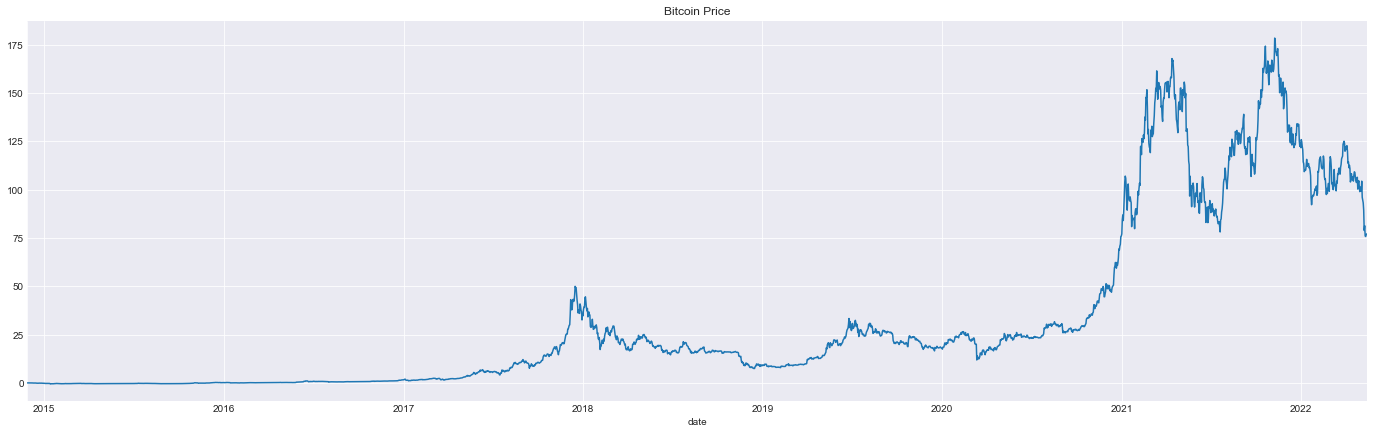

In [100]:
btc.close.plot(figsize=(24,7), title="Bitcoin Price")

In [101]:
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()

In [102]:
btc.tail()

,open,high,low,close,Volume BTC,target
date,,,,,,
2022-05-09,92.652741,88.747601,82.243198,78.945785,-0.997631,81.385378
2022-05-10,81.693363,84.619133,81.455640,81.385378,-0.997702,76.070267
2022-05-11,84.267114,83.303115,75.983027,76.070267,-0.996529,75.794382
2022-05-12,78.760142,77.907799,69.446931,75.794382,-0.994853,76.704927
2022-05-13,78.575043,80.225678,78.558394,76.704927,-0.998134,77.152280


# creat data lstm

In [103]:
prediction_days = 60

df_train_= btc[:][:len(btc)-prediction_days]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-prediction_days:]#.values.reshape(-1,1)

In [104]:
df_train_.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'target'], dtype='object')

In [105]:
# def scl(df):
#     q = df[0]
#     dq = []
#     for i in range(len(df)):
#         dq.append(q)
#     df = (np.array(df) / np.array(dq)) - 1
#     return df, q

In [106]:
# many to one

look_back_ = 5

def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
#             prev_days_, q = scl(prev_days)
            target = i[-1] / prev_days[0][3]
            sequential_data.append([np.array(prev_days), target])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train_)
trainX, trainY = trainX[2100:], trainY[2100:]
testX, testY = dataset_generator_lstm(df_test_)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testY: ", testX.shape)
print("testY", testY.shape)

trainX:  (560, 5, 5)
trainY:  (560,)
testY:  (56, 5, 5)
testY (56,)


# train

In [113]:
model = Sequential()

model.add(LSTM(units = 256,return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 128, activation="relu"))
model.add(Dropout(0.2))

# model.add(Dense(units = 64, activation="relu"))

model.add(Dense(units = 1))



model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 256)            268288    
                                                                 
 dropout_10 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 465,537
Trainable params: 465,537
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01) , loss = 'mean_squared_error')

In [115]:
batch_size = 1024

earlystopping = EarlyStopping(monitor='loss', patience=200, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='loss', patience=30, factor=0.5, min_lr=0.000001)
checkpoint_full = ModelCheckpoint(filepath='my_best_model_v010.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_full, earlystopping, rlrop]

In [116]:
# model = load_model('my_best_model_v010.hdf5')

In [117]:
history = model.fit(trainX, trainY, epochs = 300000, batch_size = batch_size, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/300000
1/1 [==============================] - ETA: 0s - loss: 1.0608
Epoch 1: loss improved from inf to 1.06078, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 121s 121s/step - loss: 1.0608 - val_loss: 0.0839 - lr: 0.0100
Epoch 2/300000
1/1 [==============================] - ETA: 0s - loss: 0.0707
Epoch 2: loss improved from 1.06078 to 0.07066, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.0707 - val_loss: 0.0216 - lr: 0.0100
Epoch 3/300000
1/1 [==============================] - ETA: 0s - loss: 0.0458
Epoch 3: loss improved from 0.07066 to 0.04577, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.0458 - val_loss: 0.0206 - lr: 0.0100
Epoch 4/300000
1/1 [==============================] - ETA: 0s - loss: 0.0435
Epoch 4: loss improved from 0.04577 to 0.04346, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 1s 1s/step - loss: 0.0317 - val_loss: 0.0100 - lr: 0.0100
Epoch 36/300000
1/1 [==============================] - ETA: 0s - loss: 0.0288
Epoch 36: loss improved from 0.02891 to 0.02884, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.0288 - val_loss: 0.0094 - lr: 0.0100
Epoch 37/300000
1/1 [==============================] - ETA: 0s - loss: 0.0275
Epoch 37: loss improved from 0.02884 to 0.02751, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.0275 - val_loss: 0.0086 - lr: 0.0100
Epoch 38/300000
1/1 [==============================] - ETA: 0s - loss: 0.0271
Epoch 38: loss improved from 0.02751 to 0.02713, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.0271 - val_loss: 0.0118 - lr: 0.0100
Epoch 39/300000
1/1 [==============================] - ETA: 0s - loss: 0.0299
Epoch 39: loss did not improve fr

Epoch 72/300000
1/1 [==============================] - ETA: 0s - loss: 0.0229
Epoch 72: loss improved from 0.02368 to 0.02292, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 2s 2s/step - loss: 0.0229 - val_loss: 0.0093 - lr: 0.0100
Epoch 73/300000
1/1 [==============================] - ETA: 0s - loss: 0.0253
Epoch 73: loss did not improve from 0.02292
1/1 [==============================] - 1s 1s/step - loss: 0.0253 - val_loss: 0.0064 - lr: 0.0100
Epoch 74/300000
1/1 [==============================] - ETA: 0s - loss: 0.0227
Epoch 74: loss improved from 0.02292 to 0.02275, saving model to my_best_model_v010.hdf5
1/1 [==============================] - 1s 1s/step - loss: 0.0227 - val_loss: 0.0087 - lr: 0.0100
Epoch 75/300000
1/1 [==============================] - ETA: 0s - loss: 0.0234
Epoch 75: loss did not improve from 0.02275
1/1 [==============================] - 1s 1s/step - loss: 0.0234 - val_loss: 0.0089 - lr: 0.0100
Epoch 76/300000
1/1 [=============

1/1 [==============================] - ETA: 0s - loss: 0.0233
Epoch 108: loss did not improve from 0.02097
1/1 [==============================] - 1s 1s/step - loss: 0.0233 - val_loss: 0.0063 - lr: 0.0100
Epoch 109/300000
1/1 [==============================] - ETA: 0s - loss: 0.0227
Epoch 109: loss did not improve from 0.02097
1/1 [==============================] - 1s 1s/step - loss: 0.0227 - val_loss: 0.0089 - lr: 0.0100
Epoch 110/300000
1/1 [==============================] - ETA: 0s - loss: 0.0231
Epoch 110: loss did not improve from 0.02097
1/1 [==============================] - 1s 1s/step - loss: 0.0231 - val_loss: 0.0060 - lr: 0.0100
Epoch 111/300000
1/1 [==============================] - ETA: 0s - loss: 0.0230
Epoch 111: loss did not improve from 0.02097
1/1 [==============================] - 1s 1s/step - loss: 0.0230 - val_loss: 0.0082 - lr: 0.0100
Epoch 112/300000
1/1 [==============================] - ETA: 0s - loss: 0.0213
Epoch 112: loss did not improve from 0.02097
1/1 [====

1/1 [==============================] - 2s 2s/step - loss: 0.0205 - val_loss: 0.0066 - lr: 0.0100
Epoch 145/300000
1/1 [==============================] - ETA: 0s - loss: 0.0203
Epoch 145: loss did not improve from 0.01948
1/1 [==============================] - 2s 2s/step - loss: 0.0203 - val_loss: 0.0066 - lr: 0.0100
Epoch 146/300000
1/1 [==============================] - ETA: 0s - loss: 0.0203
Epoch 146: loss did not improve from 0.01948
1/1 [==============================] - 1s 1s/step - loss: 0.0203 - val_loss: 0.0058 - lr: 0.0100
Epoch 147/300000
1/1 [==============================] - ETA: 0s - loss: 0.0203
Epoch 147: loss did not improve from 0.01948
1/1 [==============================] - 1s 1s/step - loss: 0.0203 - val_loss: 0.0066 - lr: 0.0100
Epoch 148/300000
1/1 [==============================] - ETA: 0s - loss: 0.0224
Epoch 148: loss did not improve from 0.01948
1/1 [==============================] - 2s 2s/step - loss: 0.0224 - val_loss: 0.0060 - lr: 0.0100
Epoch 149/300000
1/

1/1 [==============================] - ETA: 0s - loss: 0.0224
Epoch 181: loss did not improve from 0.01838
1/1 [==============================] - 2s 2s/step - loss: 0.0224 - val_loss: 0.0058 - lr: 0.0050
Epoch 182/300000
1/1 [==============================] - ETA: 0s - loss: 0.0209
Epoch 182: loss did not improve from 0.01838
1/1 [==============================] - 2s 2s/step - loss: 0.0209 - val_loss: 0.0056 - lr: 0.0050
Epoch 183/300000
1/1 [==============================] - ETA: 0s - loss: 0.0211
Epoch 183: loss did not improve from 0.01838
1/1 [==============================] - 2s 2s/step - loss: 0.0211 - val_loss: 0.0055 - lr: 0.0050
Epoch 184/300000
1/1 [==============================] - ETA: 0s - loss: 0.0195
Epoch 184: loss did not improve from 0.01838
1/1 [==============================] - 1s 1s/step - loss: 0.0195 - val_loss: 0.0060 - lr: 0.0050
Epoch 185/300000
1/1 [==============================] - ETA: 0s - loss: 0.0195
Epoch 185: loss did not improve from 0.01838
1/1 [====

Epoch 218/300000
1/1 [==============================] - ETA: 0s - loss: 0.0194
Epoch 218: loss did not improve from 0.01675
1/1 [==============================] - 2s 2s/step - loss: 0.0194 - val_loss: 0.0056 - lr: 0.0025
Epoch 219/300000
1/1 [==============================] - ETA: 0s - loss: 0.0176
Epoch 219: loss did not improve from 0.01675
1/1 [==============================] - 1s 1s/step - loss: 0.0176 - val_loss: 0.0056 - lr: 0.0025
Epoch 220/300000
1/1 [==============================] - ETA: 0s - loss: 0.0185
Epoch 220: loss did not improve from 0.01675
1/1 [==============================] - 3s 3s/step - loss: 0.0185 - val_loss: 0.0056 - lr: 0.0025
Epoch 221/300000
1/1 [==============================] - ETA: 0s - loss: 0.0208
Epoch 221: loss did not improve from 0.01675
1/1 [==============================] - 2s 2s/step - loss: 0.0208 - val_loss: 0.0056 - lr: 0.0025
Epoch 222/300000
1/1 [==============================] - ETA: 0s - loss: 0.0200
Epoch 222: loss did not improve from 

1/1 [==============================] - ETA: 0s - loss: 0.0191
Epoch 255: loss did not improve from 0.01675
1/1 [==============================] - 2s 2s/step - loss: 0.0191 - val_loss: 0.0055 - lr: 0.0012
Epoch 256/300000
1/1 [==============================] - ETA: 0s - loss: 0.0196
Epoch 256: loss did not improve from 0.01675
1/1 [==============================] - 1s 1s/step - loss: 0.0196 - val_loss: 0.0055 - lr: 0.0012
Epoch 257/300000
1/1 [==============================] - ETA: 0s - loss: 0.0195
Epoch 257: loss did not improve from 0.01675
1/1 [==============================] - 2s 2s/step - loss: 0.0195 - val_loss: 0.0055 - lr: 0.0012
Epoch 258/300000
1/1 [==============================] - ETA: 0s - loss: 0.0188
Epoch 258: loss did not improve from 0.01675
1/1 [==============================] - 1s 984ms/step - loss: 0.0188 - val_loss: 0.0055 - lr: 0.0012
Epoch 259/300000
1/1 [==============================] - ETA: 0s - loss: 0.0182
Epoch 259: loss did not improve from 0.01675
1/1 [=

Epoch 292/300000
1/1 [==============================] - ETA: 0s - loss: 0.0185
Epoch 292: loss did not improve from 0.01675
1/1 [==============================] - 1s 800ms/step - loss: 0.0185 - val_loss: 0.0055 - lr: 6.2500e-04
Epoch 293/300000
1/1 [==============================] - ETA: 0s - loss: 0.0206
Epoch 293: loss did not improve from 0.01675
1/1 [==============================] - 2s 2s/step - loss: 0.0206 - val_loss: 0.0055 - lr: 6.2500e-04
Epoch 294/300000
1/1 [==============================] - ETA: 0s - loss: 0.0191
Epoch 294: loss did not improve from 0.01675
1/1 [==============================] - 1s 1s/step - loss: 0.0191 - val_loss: 0.0055 - lr: 6.2500e-04
Epoch 295/300000
1/1 [==============================] - ETA: 0s - loss: 0.0179
Epoch 295: loss did not improve from 0.01675
1/1 [==============================] - 1s 987ms/step - loss: 0.0179 - val_loss: 0.0055 - lr: 6.2500e-04
Epoch 296/300000
1/1 [==============================] - ETA: 0s - loss: 0.0199
Epoch 296: loss

Epoch 328/300000
1/1 [==============================] - ETA: 0s - loss: 0.0201
Epoch 328: loss did not improve from 0.01647
1/1 [==============================] - 1s 995ms/step - loss: 0.0201 - val_loss: 0.0054 - lr: 3.1250e-04
Epoch 329/300000
1/1 [==============================] - ETA: 0s - loss: 0.0198
Epoch 329: loss did not improve from 0.01647
1/1 [==============================] - 1s 700ms/step - loss: 0.0198 - val_loss: 0.0054 - lr: 3.1250e-04
Epoch 330/300000
1/1 [==============================] - ETA: 0s - loss: 0.0200
Epoch 330: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0200 - val_loss: 0.0055 - lr: 3.1250e-04
Epoch 331/300000
1/1 [==============================] - ETA: 0s - loss: 0.0219
Epoch 331: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0219 - val_loss: 0.0054 - lr: 3.1250e-04
Epoch 332/300000
1/1 [==============================] - ETA: 0s - loss: 0.0174
Epoch 332: loss

1/1 [==============================] - ETA: 0s - loss: 0.0211
Epoch 364: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0211 - val_loss: 0.0054 - lr: 1.5625e-04
Epoch 365/300000
1/1 [==============================] - ETA: 0s - loss: 0.0198
Epoch 365: loss did not improve from 0.01647
1/1 [==============================] - 2s 2s/step - loss: 0.0198 - val_loss: 0.0054 - lr: 1.5625e-04
Epoch 366/300000
1/1 [==============================] - ETA: 0s - loss: 0.0193
Epoch 366: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0193 - val_loss: 0.0054 - lr: 1.5625e-04
Epoch 367/300000
1/1 [==============================] - ETA: 0s - loss: 0.0196
Epoch 367: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0196 - val_loss: 0.0054 - lr: 1.5625e-04
Epoch 368/300000
1/1 [==============================] - ETA: 0s - loss: 0.0166
Epoch 368: loss did not improve from 0

1/1 [==============================] - 1s 1s/step - loss: 0.0194 - val_loss: 0.0054 - lr: 7.8125e-05
Epoch 401/300000
1/1 [==============================] - ETA: 0s - loss: 0.0210
Epoch 401: loss did not improve from 0.01647
1/1 [==============================] - 1s 935ms/step - loss: 0.0210 - val_loss: 0.0054 - lr: 7.8125e-05
Epoch 402/300000
1/1 [==============================] - ETA: 0s - loss: 0.0205
Epoch 402: loss did not improve from 0.01647
1/1 [==============================] - 2s 2s/step - loss: 0.0205 - val_loss: 0.0054 - lr: 7.8125e-05
Epoch 403/300000
1/1 [==============================] - ETA: 0s - loss: 0.0201
Epoch 403: loss did not improve from 0.01647
1/1 [==============================] - 2s 2s/step - loss: 0.0201 - val_loss: 0.0054 - lr: 7.8125e-05
Epoch 404/300000
1/1 [==============================] - ETA: 0s - loss: 0.0174
Epoch 404: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0174 - val_loss: 0.0054 - lr: 7.8125e

Epoch 437/300000
1/1 [==============================] - ETA: 0s - loss: 0.0183
Epoch 437: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0183 - val_loss: 0.0054 - lr: 1.9531e-05
Epoch 438/300000
1/1 [==============================] - ETA: 0s - loss: 0.0197
Epoch 438: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0197 - val_loss: 0.0054 - lr: 1.9531e-05
Epoch 439/300000
1/1 [==============================] - ETA: 0s - loss: 0.0181
Epoch 439: loss did not improve from 0.01647
1/1 [==============================] - 1s 833ms/step - loss: 0.0181 - val_loss: 0.0054 - lr: 1.9531e-05
Epoch 440/300000
1/1 [==============================] - ETA: 0s - loss: 0.0176
Epoch 440: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0176 - val_loss: 0.0054 - lr: 1.9531e-05
Epoch 441/300000
1/1 [==============================] - ETA: 0s - loss: 0.0184
Epoch 441: loss di

1/1 [==============================] - ETA: 0s - loss: 0.0187
Epoch 473: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0187 - val_loss: 0.0054 - lr: 9.7656e-06
Epoch 474/300000
1/1 [==============================] - ETA: 0s - loss: 0.0198
Epoch 474: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0198 - val_loss: 0.0054 - lr: 9.7656e-06
Epoch 475/300000
1/1 [==============================] - ETA: 0s - loss: 0.0172
Epoch 475: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0172 - val_loss: 0.0054 - lr: 9.7656e-06
Epoch 476/300000
1/1 [==============================] - ETA: 0s - loss: 0.0185
Epoch 476: loss did not improve from 0.01647
1/1 [==============================] - 2s 2s/step - loss: 0.0185 - val_loss: 0.0054 - lr: 9.7656e-06
Epoch 477/300000
1/1 [==============================] - ETA: 0s - loss: 0.0195
Epoch 477: loss did not improve from 0

1/1 [==============================] - 1s 1s/step - loss: 0.0179 - val_loss: 0.0054 - lr: 4.8828e-06
Epoch 510/300000
1/1 [==============================] - ETA: 0s - loss: 0.0210
Epoch 510: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0210 - val_loss: 0.0054 - lr: 4.8828e-06
Epoch 511/300000
1/1 [==============================] - ETA: 0s - loss: 0.0211
Epoch 511: loss did not improve from 0.01647
1/1 [==============================] - 2s 2s/step - loss: 0.0211 - val_loss: 0.0054 - lr: 4.8828e-06
Epoch 512/300000
1/1 [==============================] - ETA: 0s - loss: 0.0198
Epoch 512: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0198 - val_loss: 0.0054 - lr: 4.8828e-06
Epoch 513/300000
1/1 [==============================] - ETA: 0s - loss: 0.0180
Epoch 513: loss did not improve from 0.01647
1/1 [==============================] - 1s 1s/step - loss: 0.0180 - val_loss: 0.0054 - lr: 4.8828e-06

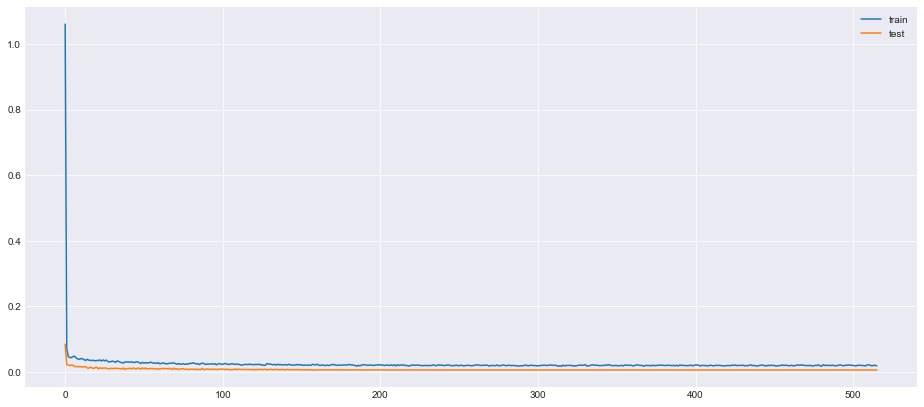

In [118]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [119]:
model_from_saved_checkpoint = load_model('my_best_model_v010.hdf5')

# test test

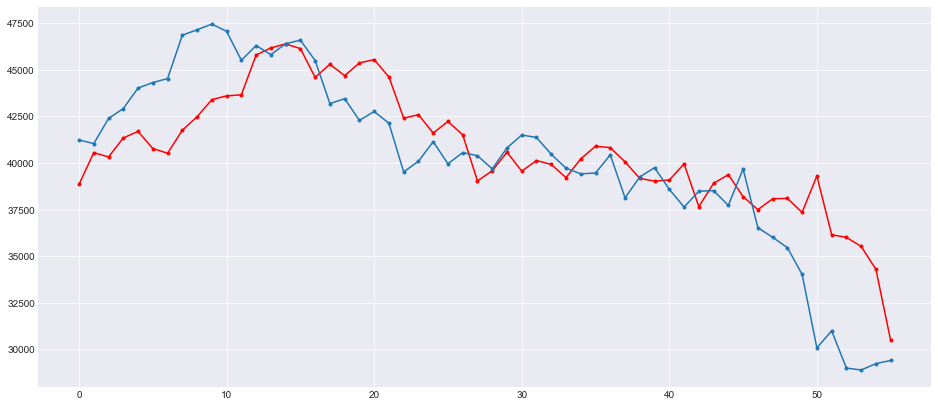

In [124]:
plt.figure(figsize=(16,7))

predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
testY_ = testY.copy()

for i in range(len(predicted_btc_price_test_data)):
    predicted_btc_price_test_data[i] = ((predicted_btc_price_test_data[i] * testX[i][0][3]) + 1)* scleR[3]
    testY_[i] = (((testY[i] * testX[i][0][3]) + 1) * scleR[3])
    
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(testY_, marker='.', label='Actual Test')

# test train

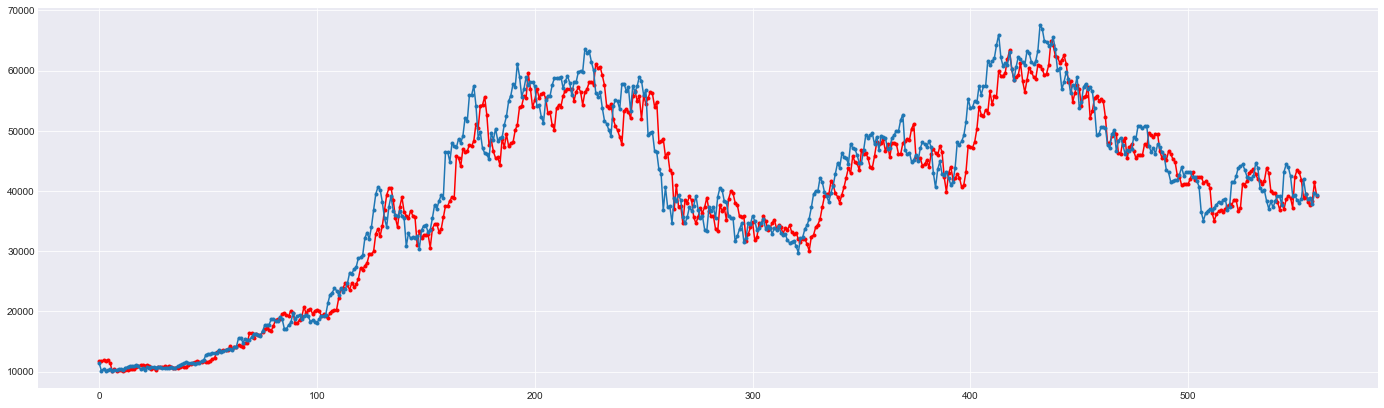

In [125]:
plt.figure(figsize=(24,7))

predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
trainY_ =trainY.copy()
for i in range(len(predicted_btc_price_train_data)):
    predicted_btc_price_train_data[i] = ((predicted_btc_price_train_data[i] * trainX[i][0][3]) + 1)* scleR[3]
    trainY_[i] = (((trainY[i] * trainX[i][0][3]) + 1) * scleR[3])

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
plt.plot(trainY_, marker='.', label='Actual Test')

# future

###### many to one

In [ ]:
from collections import deque
SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [265]:
y_p_ = []
future_len = 180
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,1).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)
  prev_days.append(per.reshape(-1,1))
  y_p_.append(per.reshape(-1,1))
  # y_p_.append(scaler.inverse_transform(per.reshape(-1,1)))


In [257]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [258]:
actual = np.concatenate((train_actual,test_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

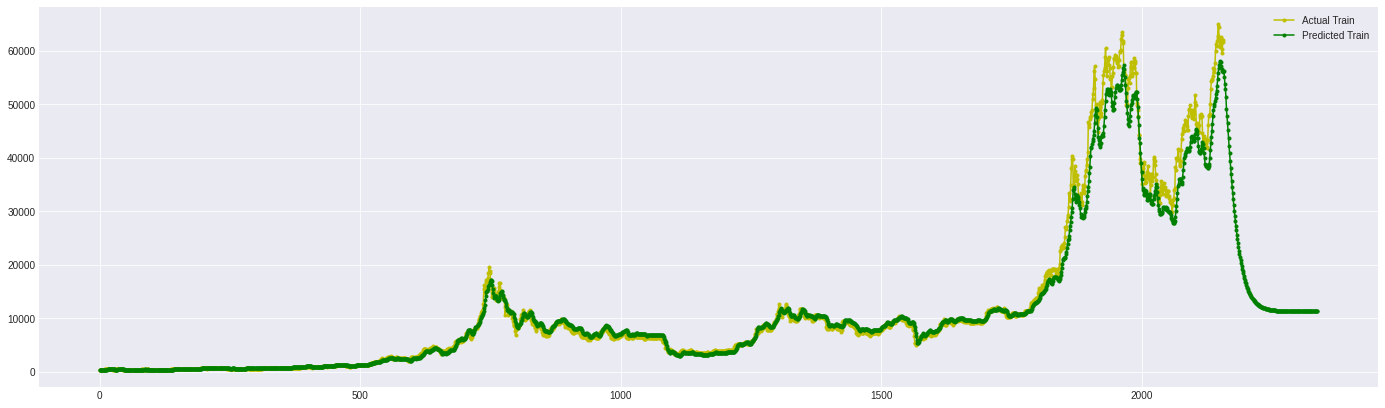

In [268]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()